<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/3%20-%20Economics/6.439%20-%20Problem%20Set%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 3 - Statistics, Computation and Applications

(c) Felipe del Canto, October 2021
***
***

# Part 0 (Execute first!)

In [53]:
from IPython.display import clear_output

# Update statsmodel
!pip install statsmodels --upgrade

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS3_data.zip

# Unzip
!unzip -o PS3_data.zip
!rm *.z* -r __MACOSX

# Clear output
clear_output()

# Import packages
import datetime
import warnings

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import seaborn           as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

import statsmodels.api         as sm
import statsmodels.formula.api as smf

In [2]:
def fit_npoly_trend(data=None, dep='', n=1, predict=False, residuals=False, sufix='', verbose=True):
  # Create necessary variables
  variables_model = ['t' + f'_{i:d}'*(i>1) for i in range(1,n+1)]

  for pow,var in enumerate(variables_model):
    if pow+1 == 1:
      data[var] = data.index + 1.0
    
    else:
      data[var] = data['t']**(pow+1)
  
  # Write model and fit it (default includes constant)
  formula = dep + ' ~ ' + '+'.join(variables_model)
  ols = smf.ols(formula=formula, data=data, missing='drop', hasconst=False).fit()

  # Print results
  if verbose:
    print(ols.summary())

  # Predict variable and residuals
  if predict or residuals:
    predict_from_model(data, dep, ols, sufix, store_predict=predict, residuals=residuals)
  
  return ols

def predict_from_model(data, dep, model, sufix, store_predict=True, residuals=False):
  # Define predicted variable name
  pred_var = dep + '_pred' + sufix

  # Predict for values that are not nan
  data.loc[data[dep].notna(), pred_var] = model.predict()

  # If residuals are required, define a new variable
  if residuals:
    data['res'+sufix] = data[dep] - data[pred_var]

  # If not storing the predicted variable, remove it
  if not store_predict:
    data.drop(pred_var, inplace=True)

  return None

def obtain_dates_and_lims(dates, offset):
  # Obtain DateIndex object
  dates = pd.to_datetime(dates)
  
  # Compute min and max using Offsets pandas objects
  date_min = dates[0]  - offset * pd.offsets.YearBegin(1)
  date_max = dates[-1] + offset * pd.offsets.YearBegin(1)

  lims = [date_min, date_max]

  return dates, lims

In [20]:
def fit_arima(data=None, dep='', order=(), obtain_mse= True, verbose=True):
  # Fit model
  arima = sm.tsa.ARIMA(endog=data[dep], order=order).fit()

  # Obtain MSE
  mse = np.mean(arima.resid**2)

  # Print results
  if verbose:
    print(arima.summary())

    if obtain_mse:
      print(f'MSE = {mse:.5f}')

  # Return
  if obtain_mse:
    return arima, mse
  else:
    return arima

# Problem 3.1: The Manua Loa $\text{CO}_2$ concentration.

In [ ]:
# Write column names
old_colnames = ['year', 'month', 'date_excel', 'date_num', 'co2',
            'co2_season_adj', # season adjusted using substracting 4-harmonic fit
            'co2_fit',        # cubic spline
            'co2_season_adj_fit', # fit substracting season adj
            'co2_filled',         # filled with co2_fit
            'co2_season_adj_filled'] # season adjusted column filled with co2_season_adj_fit

# Load data
co2_data = pd.read_csv('CO2Data.csv',index_col=False, names=old_colnames, skiprows=59)

# Replace missing values with NANs
missing_value_code = -99.99
co2_data.replace(to_replace = missing_value_code, value=pd.NA, inplace=True)

# Create date variable
co2_data['date'] = co2_data['year'].apply(str) + "/" + co2_data['month']. apply(str) + "/15"
co2_data['date'] = pd.to_datetime(co2_data['date'], format="%Y/%m/%d")

# Delete date_excel and date_num columns
colnames = ['date'] + [colname for colname in old_colnames if colname.find("date") == -1]
co2_data = co2_data[colnames]

In [ ]:
co2_data.describe(include='all', datetime_is_numeric=True)

,date,year,month,co2,co2_season_adj,co2_fit,co2_season_adj_fit,co2_filled,co2_season_adj_filled
count,706,706.0000,706.0000,698.0000,698.0000,703.0000,703.0000,703.0000,703.0000
mean,1987-07-31 06:21:24.985835712,1987.0822,6.5142,352.0019,351.9928,351.7580,351.7441,351.7632,351.7493
min,1958-03-15 00:00:00,1958.0000,1.0000,313.2100,314.4200,312.4400,314.9000,312.4400,314.4200
25%,1972-11-22 12:00:00,1972.0000,4.0000,328.4825,328.9275,328.3250,328.1950,328.1100,328.2800
50%,1987-07-30 12:00:00,1987.0000,7.0000,349.5300,349.5400,349.3000,348.8500,348.9600,348.7600
75%,2002-04-07 06:00:00,2002.0000,9.7500,372.7625,372.2725,372.2400,372.0850,372.2800,372.1500
max,2016-12-15 00:00:00,2016.0000,12.0000,407.6500,404.7300,407.2300,404.6200,407.6500,404.7300
std,NaN,16.9953,3.4490,25.9608,25.8717,26.0202,25.9373,26.0232,25.9403


## (a)

### Fit linear model and predict, with residuals 

In [ ]:
fit_kwargs_a = {'data'      : co2_data,
                'dep'       : 'co2',
                'n'         : 1,
                'predict'   : True,
                'residuals' : True,
                'sufix'     : '_a'}

ols_a = fit_npoly_trend(**fit_kwargs_a)

                                 OLS Regression Results                                
Dep. Variable:                    co2   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.885e+06
Date:                Thu, 21 Oct 2021   Prob (F-statistic):                        0.00
Time:                        19:26:10   Log-Likelihood:                         -1936.2
No. Observations:                 698   AIC:                                      3876.
Df Residuals:                     696   BIC:                                      3885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Plot fit

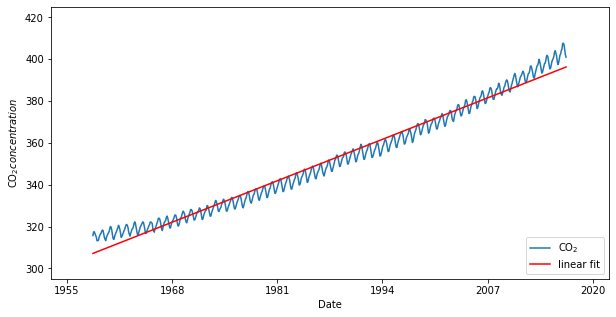

In [ ]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.lineplot(data=co2_data, x='date', y='co2', label=r'CO$_2$', ax=ax)
sns.lineplot(data=co2_data, x='date', y='co2_pred_a', label='linear fit', color = 'red', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2 concentration$")

# Set legend location
plt.legend(loc='lower right')

# Show figure
fig.show()

### Plot residuals

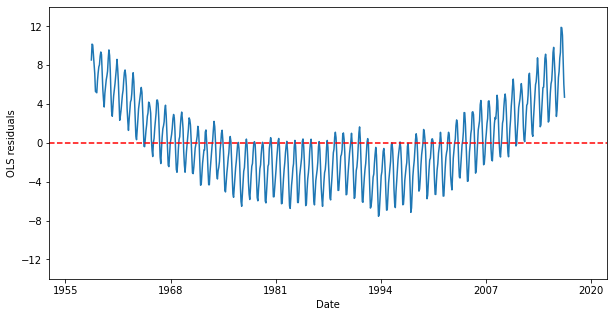

In [ ]:
# Axis offsets
offset = (2, 2)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and horizontal axis line
sns.lineplot(data=co2_data, x='date', y='res_a', ax=ax)
l = plt.axhline(linestyle='--', color = 'red')

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [-12 + 4*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel("OLS residuals")

# Show figure
fig.show()

### Compute and plot ACF

In [ ]:
acf_kwargs_a = {'nlags'   : 40,
                'missing' : 'conservative',
                'fft'     : True}

corr_a = sm.tsa.acf(co2_data['res_a'], **acf_kwargs_a)

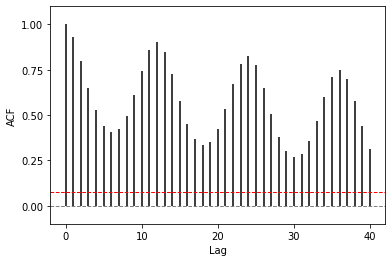

In [ ]:
# Axis offset
offset = (None, 0.1)

# Initialize figure
fig, ax = plt.subplots()

# Set number of (not NaN) observations and upper side of CI around 0.
N = co2_data['co2'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

# Define xvariable and plot ACF
lags = [i for i in range(acf_kwargs_a['nlags']+1)]
plt.vlines(lags, 0, corr_a)

# Draw x axis and upper line of CI around 0 
plt.axhline(y=z_alpha, linestyle='--', linewidth=1, color = 'red')
l = plt.axhline(y=0, linestyle='--', linewidth = 1, color = 'gray')

# Set xticks and yticks
xticks = [10*k for k in range(5)]
plt.xticks(xticks)

yticks = [0.25*k for k in range(5)]
plt.yticks(yticks)
ax.set_ylim([yticks[0] - offset[1], yticks[-1] + offset[1]])

# Set xlabel and ylabel
plt.xlabel("Lag")
plt.ylabel("ACF")

# Show figure
fig.show()

## (b)

### Fit quadratic model and predict, with residuals 

In [ ]:
fit_kwargs_b = {'data'      : co2_data,
                'dep'       : 'co2',
                'n'         : 2,
                'predict'   : True,
                'residuals' : True,
                'sufix'     : '_b'}

ols_b = fit_npoly_trend(**fit_kwargs_b)

                                 OLS Regression Results                                
Dep. Variable:                    co2   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.910e+06
Date:                Thu, 21 Oct 2021   Prob (F-statistic):                        0.00
Time:                        19:26:11   Log-Likelihood:                         -1543.9
No. Observations:                 698   AIC:                                      3094.
Df Residuals:                     695   BIC:                                      3107.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Plot fit

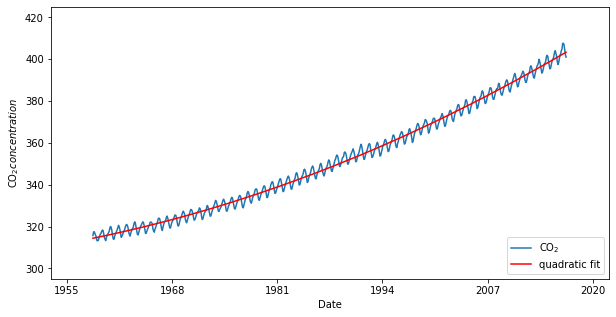

In [ ]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.lineplot(data=co2_data, x='date', y='co2', label=r'CO$_2$', ax=ax)
sns.lineplot(data=co2_data, x='date', y='co2_pred_b', label='quadratic fit', color = 'red', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2 concentration$")

# Set legend location
plt.legend(loc='lower right')

# Show figure
fig.show()

### Plot residuals

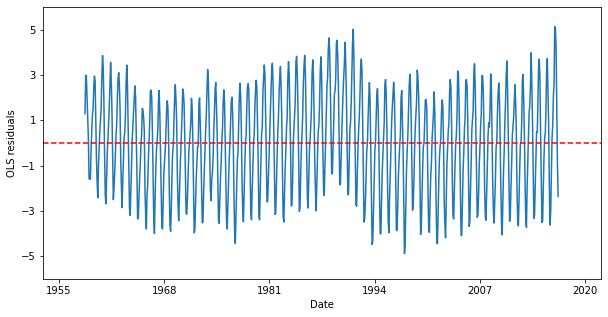

In [ ]:
# Axis offsets
offset = (2, 1)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.lineplot(data=co2_data, x='date', y='res_b', ax=ax)
l = plt.axhline(linestyle='--', color = 'red')

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [-5 + 2*k for k in range(6)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel("OLS residuals")

# Show figure
fig.show()

### Compute and plot ACF

In [ ]:
acf_kwargs_b = {'nlags'   : 40,
                'missing' : 'conservative',
                'fft'     : True}

corr_b = sm.tsa.acf(co2_data['res_b'], **acf_kwargs_b)

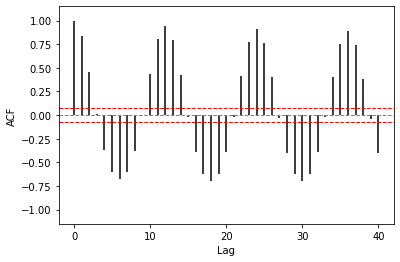

In [ ]:
# Axis offset
offset = (None, 0.15)

# Initialize figure
fig, ax = plt.subplots()

# Set number of (not NaN) observations and upper side of CI around 0.
N = co2_data['co2'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

# Define xvariable and plot ACF
lags = [i for i in range(acf_kwargs_b['nlags']+1)]
plt.vlines(lags, 0, corr_b)

# Draw x axis and upper line of CI around 0 
plt.axhline(y=z_alpha, linestyle='--', linewidth=1, color = 'red')
l = plt.axhline(y=0, linestyle='--', linewidth = 1, color = 'gray')
plt.axhline(y=-z_alpha, linestyle='--', linewidth=1, color = 'red')

# Set xticks and yticks
xticks = [10*k for k in range(5)]
plt.xticks(xticks)

yticks = [-1 + 0.25*k for k in range(9)]
plt.yticks(yticks)
ax.set_ylim([yticks[0] - offset[1], yticks[-1] + offset[1]])

# Set xlabel and ylabel
plt.xlabel("Lag")
plt.ylabel("ACF")

# Show figure
fig.show()

## (c)

#### Fit quartic model and predict, with residuals 

In [ ]:
fit_kwargs_c = {'data'      : co2_data,
                'dep'       : 'co2',
                'n'         : 4,
                'predict'   : True,
                'residuals' : True,
                'sufix'     : '_c'}

ols_c = fit_npoly_trend(**fit_kwargs_c)

                                 OLS Regression Results                                
Dep. Variable:                    co2   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.685e+06
Date:                Thu, 21 Oct 2021   Prob (F-statistic):                        0.00
Time:                        19:26:12   Log-Likelihood:                         -1529.4
No. Observations:                 698   AIC:                                      3069.
Df Residuals:                     693   BIC:                                      3092.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Plot fit

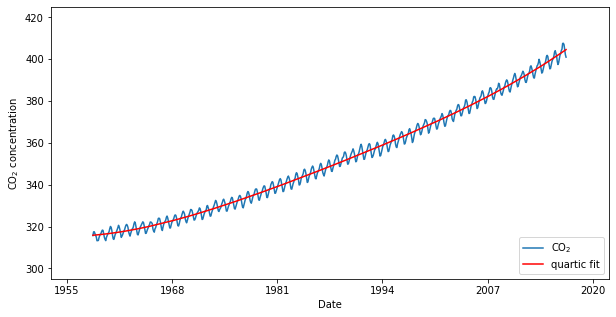

In [ ]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.lineplot(data=co2_data, x='date', y='co2', label=r'CO$_2$', ax=ax)
sns.lineplot(data=co2_data, x='date', y='co2_pred_c', label='quartic fit', color = 'red', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$ concentration")

# Set legend location
plt.legend(loc='lower right')

# Show figure
fig.show()

#### Plot residuals

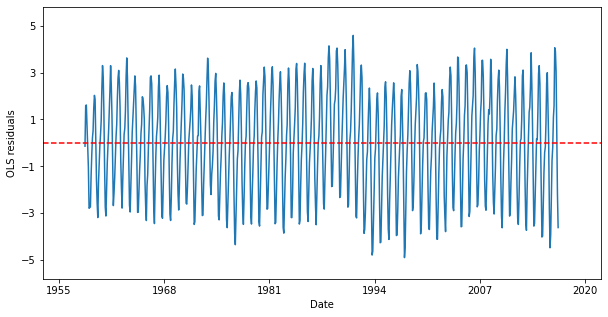

In [ ]:
# Axis offsets
offset = (2, 0.8)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.lineplot(data=co2_data, x='date', y='res_c', ax=ax)
l = plt.axhline(linestyle='--', color = 'red')

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [-5 + 2*k for k in range(6)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel("OLS residuals")

# Show figure
fig.show()

#### Compute and plot ACF

In [ ]:
acf_kwargs_c = {'nlags'   : 40,
                'missing' : 'conservative',
                'fft'     : True}

corr_c = sm.tsa.acf(co2_data['res_c'], **acf_kwargs_c)

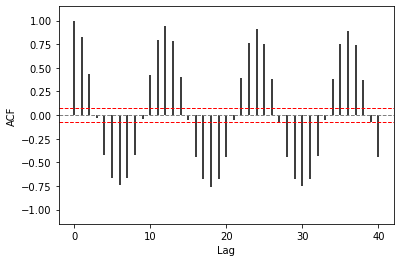

In [ ]:
# Axis offset
offset = (None, 0.15)

# Initialize figure
fig, ax = plt.subplots()

# Set number of (not NaN) observations and upper side of CI around 0.
N = co2_data['co2'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

# Define xvariable and plot ACF
lags = [i for i in range(acf_kwargs_c['nlags']+1)]
plt.vlines(lags, 0, corr_c)

# Draw x axis and upper line of CI around 0 
plt.axhline(y=z_alpha, linestyle='--', linewidth=1, color = 'red')
l = plt.axhline(y=0, linestyle='--', linewidth = 1, color = 'gray')
plt.axhline(y=-z_alpha, linestyle='--', linewidth=1, color = 'red')

# Set xticks and yticks
xticks = [10*k for k in range(5)]
plt.xticks(xticks)

yticks = [-1 + 0.25*k for k in range(9)]
plt.yticks(yticks)
ax.set_ylim([yticks[0] - offset[1], yticks[-1] + offset[1]])

# Set xlabel and ylabel
plt.xlabel("Lag")
plt.ylabel("ACF")

# Show figure
fig.show()

## (d)

### Compute monthly average of residuals for quadratic fit

In [ ]:
# Compute month averages of the residuals and assign them to a new column 
p_i = co2_data['res_b'].groupby(co2_data['month']).mean()
co2_data['period_b'] = co2_data['res_b'].groupby(co2_data['month']).transform('mean')

### Plot the averages

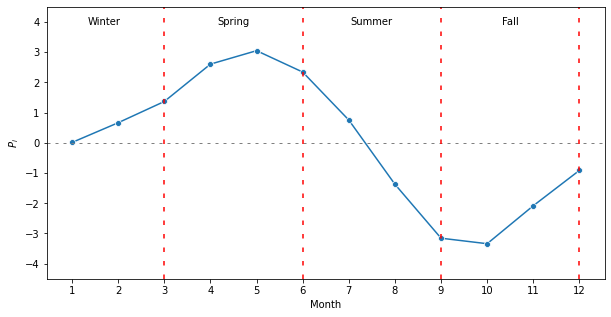

In [ ]:
# Draw seasons
seasons = True

# Axis offsets
offset = (None,0.5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
months = [i for i in range(1,13)]
sns.lineplot(x=months, y=p_i, marker='o', ax=ax)
l = plt.axhline(linestyle='--', linewidth = 1, color = 'gray')
l.set_dashes([3,5])

# Draw seasons
if seasons:
  for month in [3, 6, 9, 12]:
    l = plt.axvline(x=month,  linewidth = 1.5, linestyle='--', color='red')
    l.set_dashes([3,6])

  plt.text(1.7, 4, "Winter", horizontalalignment ='center', verticalalignment='center')
  plt.text(4.5, 4, "Spring", horizontalalignment ='center', verticalalignment='center')
  plt.text(7.5, 4, "Summer", horizontalalignment ='center', verticalalignment='center')
  plt.text(10.5, 4, "Fall",  horizontalalignment ='center', verticalalignment='center')

# Set xticks and yticks
xticks = months
plt.xticks(xticks)

yticks = [-4 + k for k in range(9)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Month")
plt.ylabel(r"$P_i$")

# Show figure
fig.show()

### Adjust for seasonality

In [ ]:
# Remove seasonal component (monthly averages of residuals)
co2_data['co2_season_adj_b'] = co2_data['co2'] - co2_data['period_b']

### Plot the adjusted series

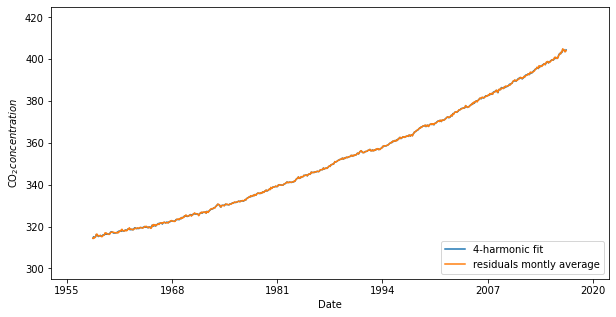

In [ ]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.lineplot(data=co2_data, 
             x='date', y='co2_season_adj', 
             label='4-harmonic fit', ax=ax)
sns.lineplot(data=co2_data, 
             x='date', y='co2_season_adj_b', 
             label='residuals montly average', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2 concentration$")

# Location of legend
plt.legend(loc='lower right')

# Show figure
fig.show()

### Compare with provided seasonally adjusted series

In [ ]:
# Compare with provided seasonally adjusted series
co2_data['diff_season_adj'] = co2_data['co2_season_adj'] - co2_data['co2_season_adj_b']
co2_data['diff_season_adj_rel'] = co2_data['diff_season_adj']/co2_data['co2_season_adj'] * 100
co2_data[['diff_season_adj', 'diff_season_adj_rel']].describe()

,diff_season_adj,diff_season_adj_rel
count,698.0000,698.0000
mean,-0.0092,-0.0026
std,0.1264,0.0362
min,-0.3582,-0.1133
25%,-0.0814,-0.0244
50%,-0.0040,-0.0013
75%,0.0582,0.0168
max,0.3446,0.0979


## (e)

### Compute the seasonally adjusted fit

In [ ]:
co2_data['co2_season_adj_fit_b'] = co2_data['co2_pred_b'] + co2_data['period_b']

### Plot the seasonally adjusted fit

In [ ]:
pd.to_datetime(xticks)[0]- pd.offsets.MonthBegin(1)

Timestamp('1954-12-01 00:00:00')

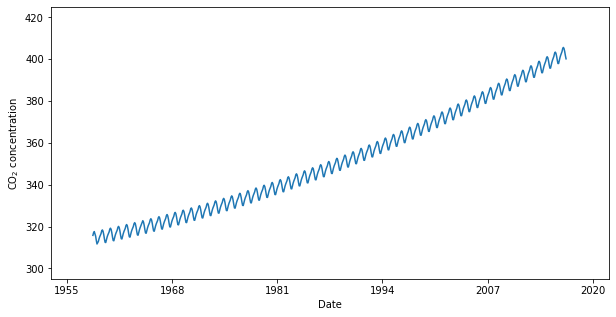

In [ ]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.lineplot(data=co2_data, x='date', y='co2_season_adj_fit_b', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$ concentration")

# Show figure
fig.show()

### Compute the residual series, after removing the seasonally adjusted fit

In [ ]:
# Compare with original series
co2_data['diff_season_adj_fit'] = co2_data['co2'] - co2_data['co2_season_adj_fit']
co2_data['diff_season_adj_fit_rel'] = co2_data['diff_season_adj_fit']/co2_data['co2'] * 100
co2_data[['diff_season_adj_fit', 'diff_season_adj_fit_rel']].describe()

,diff_season_adj_fit,diff_season_adj_fit_rel
count,698.0000,698.0000
mean,0.0144,0.0004
std,2.1140,0.6007
min,-4.0400,-1.1105
25%,-1.7650,-0.5008
50%,0.3400,0.0996
75%,1.8675,0.5328
max,3.9600,1.0575


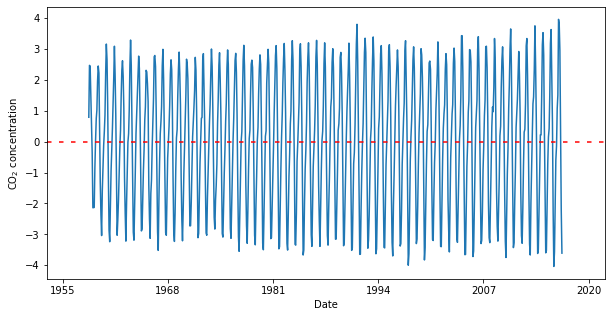

In [ ]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and horizontal x axis line
sns.lineplot(data=co2_data, x='date', y='diff_season_adj_fit', ax=ax)
l = plt.axhline(linestyle='--', color = 'red')
l.set_dashes([3,5])

# Set xticks and yticks
xticks = [f'{1955+10*k:d}' for k in range(7)]
plt.xticks(pd.to_datetime(xticks), xticks)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$ concentration")

# Show figure
fig.show()

### Compute and plot the ACF for the residual series

In [ ]:
acf_kwargs_e = {'nlags'   : 40,
                'missing' : 'conservative',
                'fft'     : True}

corr_e = sm.tsa.acf(co2_data['diff_season_adj_fit'], **acf_kwargs_e)

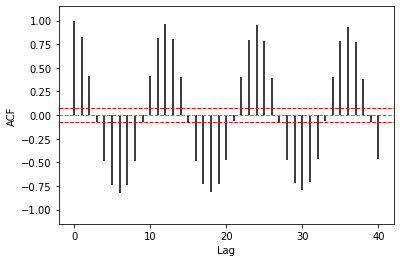

In [ ]:
# Axis offset
offset = (None, 0.15)

# Initialize figure
fig, ax = plt.subplots()

# Set number of (not NaN) observations and upper side of CI around 0.
N = co2_data['co2'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

# Define xvariable and plot ACF
lags = [i for i in range(acf_kwargs_c['nlags']+1)]
plt.vlines(lags, 0, corr_e)

# Draw x axis and upper line of CI around 0 
plt.axhline(y=z_alpha, linestyle='--', linewidth=1, color = 'red')
l = plt.axhline(y=0, linestyle='--', linewidth = 1, color = 'gray')
plt.axhline(y=-z_alpha, linestyle='--', linewidth=1, color = 'red')

# Set xticks and yticks
xticks = [10*k for k in range(5)]
plt.xticks(xticks)

yticks = [-1 + 0.25*k for k in range(9)]
plt.yticks(yticks)
ax.set_ylim([yticks[0] - offset[1], yticks[-1] + offset[1]])

# Set xlabel and ylabel
plt.xlabel("Lag")
plt.ylabel("ACF")

# Show figure
fig.show()

# Problem 3.2: BPP Data Analysis

## Preamble

First, load the ``PriceStats_CPI` data and correct the `date` variable to be a `DateTime` object. Then, retain only the first month observations.

Then, make the $\log$ transformations to the `PriceStats` and the `CPI` variables.

In [4]:
# Load data
cpi_data = pd.read_csv('PriceStats_CPI.csv')

# Fix date object
cpi_data['date'] = pd.to_datetime(cpi_data['date'])

# Keep only first month observations
cpi_data = cpi_data.resample(rule='MS', on='date')[cpi_data.columns].agg('first')
cpi_data.reset_index(drop=True, inplace=True)

# Make log transformations
newCols = ['log_PS', 'log_CPI']
colsToTransform = ['PriceStats', 'CPI']
cpi_data[newCols] = cpi_data[colsToTransform].apply(np.log)

The `describe` method shows that the `CPI` (and consequently, the `log_CPI`) variable has a missing value. Moreover, this is the last one

In [5]:
cpi_data.describe()

,PriceStats,CPI,log_PS,log_CPI
count,124.0000,123.0000,124.0000,123.0000
mean,106.5684,105.7734,4.6676,4.6602
std,5.2430,5.0348,0.0495,0.0478
min,96.0383,96.0757,4.5647,4.5651
25%,102.3102,100.5843,4.6280,4.6110
50%,107.6719,106.5142,4.6791,4.6683
75%,109.7029,108.9919,4.6978,4.6913
max,116.4304,115.2325,4.7573,4.7470


In [6]:
cpi_data.iloc[-1,:]

date          2018-10-01 00:00:00
PriceStats               116.4304
CPI                           NaN
log_PS                     4.7573
log_CPI                       NaN
Name: 123, dtype: object

To fix this, we drop this observation from our sample.

In [7]:
cpi_data = cpi_data.iloc[:-1,:]
cpi_data.describe()

,PriceStats,CPI,log_PS,log_CPI
count,123.0000,123.0000,123.0000,123.0000
mean,106.4882,105.7734,4.6668,4.6602
std,5.1876,5.0348,0.0490,0.0478
min,96.0383,96.0757,4.5647,4.5651
25%,102.2517,100.5843,4.6274,4.6110
50%,107.6673,106.5142,4.6790,4.6683
75%,109.6604,108.9919,4.6974,4.6913
max,116.1245,115.2325,4.7547,4.7470


Now, load the Break-even rate (BER) data from `T10YIE.csv` and `T5YIE.csv`. These datasets contain the difference in yield between a fixed rate and a inflation adjusted treasury note. These notes have 10 and 5 maturity years, respectively. 

In [157]:
# Load data
ber_10y = pd.read_csv('T10YIE.csv', names=['date', 'ber'], skiprows=1)
ber_5y  = pd.read_csv('T5YIE.csv', names=['date', 'ber'], skiprows=1)

# Fix date object
ber_10y['date'] = pd.to_datetime(ber_10y['date'])
ber_5y['date'] = pd.to_datetime(ber_5y['date'])

# Replace "." rates with nan
ber_10y.replace(".", np.nan, inplace=True)
ber_5y.replace(".", np.nan, inplace=True)

# Change ber datatype
ber_10y = ber_10y.astype({'ber': 'float'})
ber_5y  = ber_5y.astype({'ber': 'float'})

# Keep first observation of each month
ber_10y = ber_10y.resample(rule='MS', on='date')[ber_10y.columns].agg('first')
ber_10y.reset_index(drop=True, inplace=True)

ber_5y = ber_5y.resample(rule='MS', on='date')[ber_5y.columns].agg('first')
ber_5y.reset_index(drop=True, inplace=True)

In [158]:
pd.merge()

,date,ber
0,2003-01-02,1.6400
1,2003-02-03,1.8100
2,2003-03-03,1.9100
3,2003-04-01,1.8200
4,2003-05-01,1.7500
5,2003-06-02,1.6000
6,2003-07-01,1.6400
7,2003-08-01,2.0400
8,2003-09-01,2.1800
9,2003-10-01,2.0000


## (a)

### Compute and plot PACF

In order to determine the order of the AR model to fit, the PACF plot with 20 lags, for the `log_CPI` variable is shown.

In [8]:
# Parameters of the PACF function
pacf_kwargs_a = {'nlags' : 20}

pacf_a = sm.tsa.pacf(cpi_data['log_CPI'], **pacf_kwargs_a)

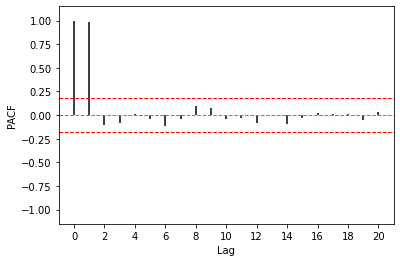

In [9]:
# Axis offset
offset = (None, 0.15)

# Set number of (not NaN) observations and upper side of CI around 0.
N = cpi_data['log_CPI'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

# Initialize figure
fig, ax = plt.subplots()

# Define xvariable and plot ACF
lags = [i for i in range(pacf_kwargs_a['nlags']+1)]
plt.vlines(lags, 0, pacf_a)

# Draw x axis and upper line of CI around 0 
plt.axhline(y=z_alpha, linestyle='--', linewidth=1, color = 'red')
l = plt.axhline(y=0, linestyle='--', linewidth = 1, color = 'gray')
plt.axhline(y=-z_alpha, linestyle='--', linewidth=1, color = 'red')

# Set xticks and yticks
xticks = [2*k for k in range(11)]
plt.xticks(xticks)

yticks = [-1 + 0.25*k for k in range(9)]
plt.yticks(yticks)
ax.set_ylim([yticks[0] - offset[1], yticks[-1] + offset[1]])

# Set xlabel and ylabel
plt.xlabel("Lag")
plt.ylabel("PACF")

# Show figure
fig.show()

### Fit AR(1) model and predict

The plot exhibits a sharp decline after lag 1, implying that an AR(1) model would be a good choice for this variable.

In [21]:
# Parameters
arma_a_params = {'data'       : cpi_data,
                 'dep'        : 'log_CPI',
                 'order'      : (1,0,0),
                 'obtain_mse' : False,
                 'verbose'    : True
                 }
                
# Fit model
ar_a = fit_arima(**arma_a_params)

# Predict
cpi_data['pred_a'] = ar_a.predict(start=1)

                               SARIMAX Results                                
Dep. Variable:                log_CPI   No. Observations:                  123
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 502.860
Date:                Mon, 01 Nov 2021   AIC                           -999.721
Time:                        13:19:01   BIC                           -991.284
Sample:                             0   HQIC                          -996.294
                                - 123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6746      0.066     71.294      0.000       4.546       4.803
ar.L1          0.9983      0.007    137.388      0.000       0.984       1.013
sigma2      1.568e-05   1.39e-06     11.283      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Next, compute the mean squared prediction error (MSPE):

In [31]:
# Compute MSPE
diff = (cpi_data['pred_a'] - cpi_data['log_CPI']).to_numpy()[1:]**2
print(f'MSPE = {np.mean(diff):.8f}')

MSPE = 1.5712642382365344e-05


The behavior of the MSPE is not monotone with the order of the model. Moreover, the AR(1) model is not the one that obtains the best predictions.

The minimum error is obtained with an AR(3) model.

In [61]:
mspe_list = []

for order in range(1,11):

  # Parameters
  arma_a2_params = {'data'       : cpi_data,
                    'dep'        : 'log_CPI',
                    'order'      : (order,0,0),
                    'obtain_mse' : False,
                    'verbose'    : False
                  }
                  
  # Fit model
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ar_a2 = fit_arima(**arma_a2_params)

  # Predict
  cpi_data['pred_a2'] = ar_a2.predict(start=1)
  
  # Compute MSPE
  diff = (cpi_data['pred_a2'] - cpi_data['log_CPI']).to_numpy()[1:]**2
  print(f'Order {order},' + ' '*(order<10) + f' MSPE = {np.mean(diff):.8f}')

  # Drop column
  cpi_data.drop(columns=['pred_a2'], inplace=True)

Order 1,  MSPE = 0.00001571
Order 2,  MSPE = 0.00001081
Order 3,  MSPE = 0.00001038
Order 4,  MSPE = 0.00001547
Order 5,  MSPE = 0.00001042
Order 6,  MSPE = 0.00001055
Order 7,  MSPE = 0.00001044
Order 8,  MSPE = 0.00001042
Order 9,  MSPE = 0.00001039
Order 10, MSPE = 0.00001041


### Plot predictions

Since the estimated coefficient for the lagged variable is almost 1, then the predicted series looks very similar to the original series, lagged by one month.

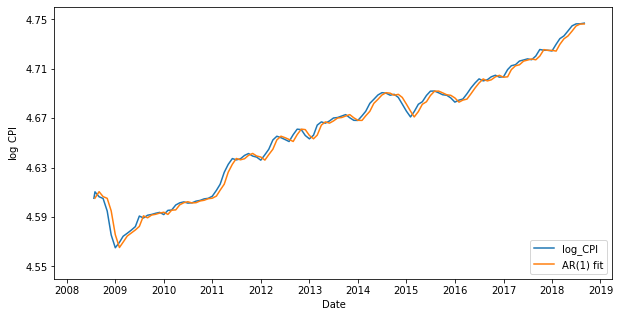

In [ ]:
# Axis offsets
offset = (3,0.01)
date_offset = pd.offsets.DateOffset(months=offset[0])

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.lineplot(data=cpi_data, x='date', y='log_CPI', label='log_CPI', ax=ax)
sns.lineplot(data= cpi_data, x='date', y='pred_a', label='AR(1) fit', ax=ax)

# Set xticks and xlim
xticks = [f'{2008+k:d}' for k in range(12)]
date_ticks = pd.to_datetime(xticks)

x_lims = [date_ticks[0] - date_offset, 
         date_ticks[-1] + date_offset]

plt.xticks(date_ticks, xticks)
ax.set_xlim(x_lims)

# Set yticks and ylim
yticks = [4.55 + 0.04*k for k in range(6)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"$\log$ CPI")

# Set legend location
plt.legend(loc='lower right')

# Show figure
fig.show()

## (b)

### Compute inflation rates

#### Real inflation rates

In [81]:
cpi_data['real_inflation'] = (cpi_data['CPI'] / cpi_data['CPI'].shift(1) - 1) * 100

#### Using CPI and predictions

In [87]:
cpi_data.head(10)

,date,PriceStats,CPI,log_PS,log_CPI,pred_a,real_inflation,pred_inflation_CPI,pred_inflation_PS
0,2008-07-24,100.0000,100.0000,4.6052,4.6052,nan,nan,nan,nan
1,2008-08-01,99.8576,100.5251,4.6037,4.6104,4.6053,0.5251,0.0119,-0.1424
2,2008-09-01,99.6544,100.1238,4.6017,4.6064,4.6105,-0.3992,0.0110,-0.2035
3,2008-10-01,99.7243,99.9854,4.6024,4.6050,4.6065,-0.1382,0.0117,0.0702
4,2008-11-01,97.9906,98.9754,4.5849,4.5949,4.6051,-1.0101,0.0119,-1.7385
5,2008-12-01,96.5471,97.0797,4.5700,4.5755,4.5950,-1.9153,0.0137,-1.4731
6,2009-01-01,96.0383,96.0757,4.5647,4.5651,4.5757,-1.0342,0.0170,-0.5270
7,2009-02-01,96.7848,96.4938,4.5725,4.5695,4.5653,0.4352,0.0188,0.7773
8,2009-03-01,97.1569,96.9737,4.5763,4.5744,4.5697,0.4973,0.0180,0.3845
9,2009-04-01,97.5255,97.2095,4.5801,4.5769,4.5746,0.2432,0.0172,0.3794


In [84]:
cpi_data['pred_inflation_CPI'] = (np.exp(cpi_data['pred_a'] - cpi_data['log_CPI'].shift(1)) - 1) * 100

#### Using PriceStats data

In [86]:
cpi_data['pred_inflation_PS'] = (cpi_data['PriceStats'] / cpi_data['PriceStats'].shift(1) - 1) * 100

#### Using BER data

## (c)

## (d)

## (e)

## (f)